#### Import potrzebnych bibliotek

In [1]:
import torch
from torchvision import datasets
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F


import warnings
warnings.filterwarnings("ignore")

#### Przygotowanie klasy wczytujacej dataset i wizualizujacej dane  (pkt. 1 i pkt. 2)

In [2]:
class FaceKeypointsDataset(Dataset):
    
    def __init__(self, csv_file, transform = None, img_size = 96):
        self.data = pd.read_csv(csv_file).dropna()                          # Pozostaja tylko rekordy z wszystkimi keypointami
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = np.fromstring(self.data.iloc[idx, -1], sep = " ").astype(np.int).reshape(-1, self.img_size)
        keypoints = self.data.iloc[idx, :-1].values.astype(np.float32)
        sample = {'image': image, 'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
        if len(image) != 96:
            raise Exception('Error: incorect img size idx: {}'.format(idx))
        
        return sample
    
    def show_sample(self, idx):
        
        image, keypoints = self[idx]['image'], self[idx]['keypoints']
        
        if isinstance(image, torch.Tensor):
            image = image.numpy().reshape(self.img_size, self.img_size)
            
        if isinstance(keypoints, torch.Tensor):
            keypoints = keypoints.numpy()
        
        fig = plt.figure(figsize = [5, 5])
        ax = plt.subplot()
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(idx))
        ax.axis('off')

        plt.imshow(image, cmap = 'gray')
        plt.scatter(keypoints[0::2], keypoints[1::2], s = 100, marker = '.', c = 'r')

        plt.show()
        

#### Normalizacja obrazka przez podzielenie przez 255 mozliwych wartosci

In [3]:
class Normalize(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255., 'keypoints': keypoints}

#### Konwersja na tensor (pkt. 2)

In [4]:
class ToTensor(object):
    
    def __init__(self, size = 96):
        self.size = size
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        image = image.reshape(1, self.size, self.size)
        image = torch.from_numpy(image)
        keypoints = torch.from_numpy(keypoints)
        return {'image': image, 'keypoints': keypoints}

#### Podzial zbioru i wczytanie do DataLoadera (pkt.3 i pkt.4)

In [5]:
def prepare_loaders(dataset, test_size = 0.2, batch_size = 128):
    
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    th = int(test_size * len(dataset))
    test_idx, train_idx = indices[:th], indices[th:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)
    
    return train_loader, valid_loader

#### Parametry, inicjalizacja obiektow wczytujacych dane, wizualizacja przykladowych sampli i podzial danych

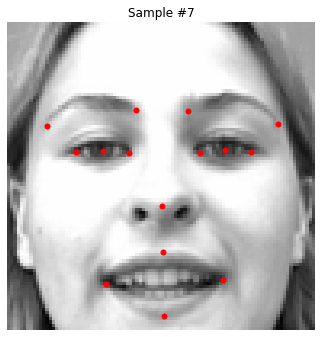

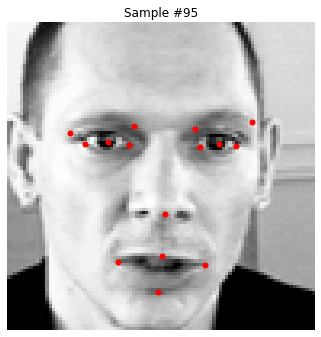

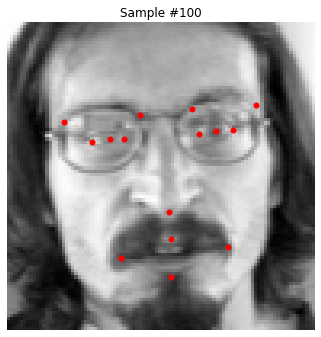

In [6]:
batch_size = 16
test_size = 0.2

trs = transforms.Compose([Normalize(), ToTensor()])
face_dataset = FaceKeypointsDataset(csv_file = 'facialkeypoints/training.csv', transform = trs)

face_dataset.show_sample(7)
face_dataset.show_sample(95)
face_dataset.show_sample(100)

train_loader, test_loader = prepare_loaders(dataset = face_dataset, test_size = test_size, batch_size = batch_size)

#### Przygotowanie sieci Multi Layer (pkt.5)

In [7]:
class MLP(nn.Module):
    
    def __init__(self, input_size, output_size, h_layers, p):
        
        super(MLP, self).__init__()
        
        h_layer_sizes = [(input_size, h_layers[0])] + list(zip(h_layers[:-1], h_layers[1:]))
        self.h_layers = nn.ModuleList([nn.Linear(h_x, h_y) for h_x, h_y in h_layer_sizes])
        self.output = nn.Linear(h_layers[-1], output_size)
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        for layer in self.h_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

#### Inicjalizacja modelu sieci

In [8]:
device = torch.device('cpu')
input_size = 96 * 96
output_size = 30
h_layers = [1000, 256, 64]
p = 0.1

model = MLP(input_size, output_size, h_layers, p)

model = model.to(device)

#### Okreslenie funkcji kosztu i optymalizatora

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Skrypt treningowy

In [10]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50):

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        
        train_loss = 0.0
        test_loss = 0.0

       
        model.train() #training
        for batch in train_loader:
            
            optimizer.zero_grad() # czysci gradient zamiast go akumulowac
           
            output = model(batch['image'].to(device).float() )
            
            loss = criterion(output, batch['keypoints'].to(device).float() )
            loss.backward()   # liczy nowy gradient z uzyciem algorytmu propagacji wstecznej
            optimizer.step()  # zmienia wagi polaczen neuronow 
            train_loss += loss.item()

       
        model.eval() #  evaluation
        for batch in test_loader:
            
            output = model(batch['image'].to(device).float() )
            
            loss = criterion(output, batch['keypoints'].to(device).float() )
             
            test_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \ Test Loss: {:.6f}'
              .format(epoch+1, train_loss, test_loss))
            
    return train_losses, test_losses 

In [11]:
train_losses, valid_losses = train(train_loader, test_loader, model, criterion, optimizer, n_epochs = 150)

Epoch: 1 	Training Loss: 431.529222 \ Test Loss: 137.045390
Epoch: 2 	Training Loss: 195.906051 \ Test Loss: 112.078820
Epoch: 3 	Training Loss: 154.425876 \ Test Loss: 106.462347
Epoch: 4 	Training Loss: 128.260924 \ Test Loss: 107.355836
Epoch: 5 	Training Loss: 140.450263 \ Test Loss: 140.744186
...


Epoch: 146 	Training Loss: 22.875534 \ Test Loss: 10.375064
Epoch: 147 	Training Loss: 22.552766 \ Test Loss: 10.908837
Epoch: 148 	Training Loss: 21.916106 \ Test Loss: 10.421092
Epoch: 149 	Training Loss: 23.099735 \ Test Loss: 10.752586
Epoch: 150 	Training Loss: 22.659999 \ Test Loss: 10.388711


#### Wizualizacja funkcji kosztu

In [12]:
plt.style.use('seaborn-darkgrid')
def plot_loss(train_losses, valid_losses):

    fig, ax1 = plt.subplots(figsize = [10, 7])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('RMSE')
    ax1.plot([i for i in range(len(train_losses))], train_losses, color = 'r', label = 'train')
    ax1.plot([i for i in range(len(valid_losses))], valid_losses, color = 'g', label = 'test')
    plt.legend()
    fig.tight_layout()  
    plt.show()
              

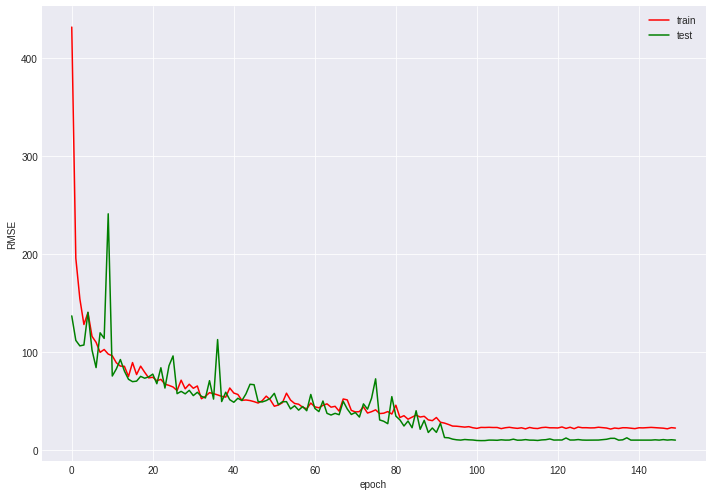

In [13]:
plot_loss(train_losses, valid_losses)

#### Predykcja pojedynczego sampla ze zbioru testowego i wizualizacja wartosci prawdziwych i prognozowanych

In [14]:
def predict_one_and_show(data_loader, model, idx):
    
    model.eval() 
    
    image = test_loader.dataset[idx]['image']
    keypoints_true = test_loader.dataset[idx]['keypoints']
    with torch.no_grad():
        keypoints_pred = model(image.to(device).float()).numpy().flatten()
        
    image = image.numpy().reshape(96, 96)
    keypoints_true = keypoints_true.numpy()
    
    fig = plt.figure(figsize = [5, 5])
    ax = plt.subplot()
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(idx))
    ax.axis('off')

    plt.imshow(image, cmap = 'gray')
    plt.scatter(keypoints_true[0::2], keypoints_true[1::2], s = 70, marker = '.', c = 'r', label = 'TRUE')
    plt.scatter(keypoints_pred[0::2], keypoints_pred[1::2], s = 100, marker = '.', c = 'y', label = 'PRED')
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.01),
          ncol=3, fancybox=True, shadow=True)
    for text, color in zip(leg.get_texts(), ['r', 'y']):
        plt.setp(text, color = color)
    plt.show()

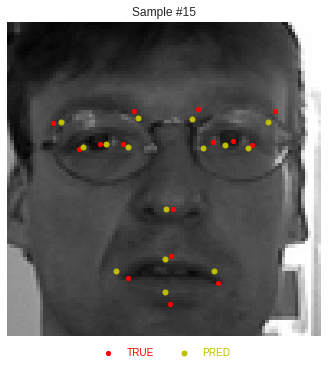

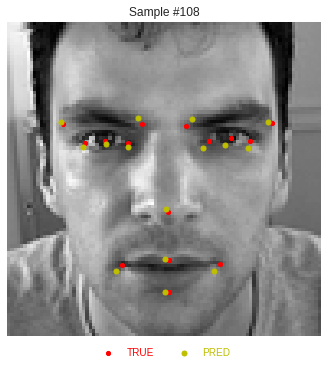

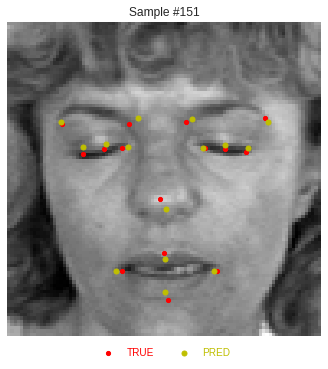

In [20]:
predict_one_and_show(test_loader, model, 15)
predict_one_and_show(test_loader, model, 108)
predict_one_and_show(test_loader, model, 151)